# <span style='color:#3b748a'>The trip data for San Francisco is TOO large to upload to GitHub.</span>

<img src="../images/bikes_banner.jpg" width="1000" />

# <span style="color:#37535e">Bicycle Share Usage</span>

##  <span style='color:#3b748a'>Plotting Ford GoBike San Francisco and weather data</span>

<span style='color:#4095b5'>This notebook explores the bike rental, weather, and daylight data for San Francisco through various plots.</span>

<span style='color:#4095b5'><b>NOTE</b>: While distance plots are created, these are not useful as distance is <b>calculated</b> from start and end hubs.</span>

## <span style='color:#3b748a'>Table of contents</span>
<ul>
    <li><span style='color:#4095b5'><a href="#import"><span style='color:#4095b5'>I. Import all data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#process"><span style='color:#4095b5'>II. Process all data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot_trip"><span style='color:#4095b5'>III. Plot the trip data (trip counts, distances, durations).</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot_other"><span style='color:#4095b5'>IV. Plot bike data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot_other"><span style='color:#4095b5'>V. Plot other trip data (hubs, etc).</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#plot_weather"><span style='color:#4095b5'>VI. Plot the weather and daylight data.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#corr"><span style='color:#4095b5'>VII. Plot correlations.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#future"><span style='color:#4095b5'>VIII. Further work.</span></a></span></li>
    <li><span style='color:#4095b5'><a href="#store"><span style='color:#4095b5'>IX. For future reference.</span></a></span></li>
</ul>


## <span style='color:#3b748a'>External data required</span>
<ul>
    <li><span style='color:#4095b5'><a href="../data/sf/trips_all.csv"><span style='color:#4095b5'>../data/sf/trips_all.csv</span></a> (NOT available in GitHub)</span></li>
    <li><span style='color:#4095b5'><a href='../data/sf/weather.csv'><span style='color:#4095b5'>../data/sf/weather.csv</span></a> (available in GitHub)</span></li>
    <li><span style='color:#4095b5'><a href='../data/sf/daylight.csv'><span style='color:#4095b5'>../data/sf/daylight.csv</span></a> (available in GitHub)</span></li>

</ul>

## <span style='color:#3b748a'>Links</span>
<ul>
    <li><span style='color:#4095b5'><a href="https://www.fordgobike.com/system-data">Ford GoBike (SF) Data</a></span></li>
    <li><span style='color:#4095b5'><a href="clean_df.ipynb"><span style='color:#4095b5'>Cleaning San Francisco rental data</span></a></span></li>
    <li><span style='color:#4095b5'><a href="weather.ipynb"><span style='color:#4095b5'>Weather data</span></a></span></li>
    <li><span style='color:#4095b5'><a href="daylight.ipynb"><span style='color:#4095b5'>Daylight data</span></a></span></li>
</ul>
<hr>

In [1]:
# Let's get the administrative stuff done first
# import all the libraries and set up the plotting

import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from geopy.distance import vincenty

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
colors_palette = sns.color_palette("GnBu_d")
sns.set_palette(colors_palette)
%matplotlib inline

# GnBu_d
colors = ['#37535e', '#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf', '#c5e5eaff']


<hr>
<a name="import"> </a>
## <span style='color:#3b748a'>I. Import all data.</span>

In [2]:
# NOTE: The trips_all.csv for bos, chi, phil, sf are TOO big to push to the GitHub repository
# NOTE: I don't have cleaned trip data for DC and NYC yet
# 'atl', 'bos', 'chi', 'la', 'phl', 'sf', 'dc', 'nyc'

city_code = 'sf'
city_name = "San Francisco"

In [3]:
# Read and clean data for one city

# Bike trips for city
df_trips = pd.read_csv('../data/' + city_code + '/trips_all.csv')

# Weather for city
df_weather = pd.read_csv('../data/' + city_code + '/weather.csv')
df_weather.drop(['dew_avg', 'dew_max', 'dew_min', 'hum_max', 'hum_min', 'sea_avg', 'sea_max', 'sea_min',
         'temp_max', 'temp_min', 'vis_avg', 'vis_max', 'vis_min', 'wind_max', 'wind_unk'], 
        axis=1, inplace=True)

# A little cleaning
df_weather['prec'].replace(to_replace='T',value = '0.01', inplace=True)
df_weather['prec'] = df_weather['prec'].astype(float)

# For merging
df_weather.rename(columns={'date': 'Start Date'}, inplace=True)

# Daylight for city
df_daylight = pd.read_csv('../data/' + city_code + '/daylight.csv')

# For merging
df_daylight.rename(columns={'Date': 'Start Date'}, inplace=True)

<hr>
<a name="process"> </a>
## <span style='color:#3b748a'>II. Process all data.</span>

In [4]:
# Type cast must happen after reading from csv    
df_trips['Start Date'] = pd.to_datetime(df_trips['Start Date'])
df_trips['End Date'] = pd.to_datetime(df_trips['End Date'])
df_trips['Start Time'] = pd.to_datetime(df_trips['Start Time'])
df_trips['End Time'] = pd.to_datetime(df_trips['End Time'])
df_trips['Duration'] = pd.to_timedelta(df_trips['Duration'], unit='m')
df_trips['Duration'] = (df_trips['Duration'].dt.total_seconds()/60) # minutes

# Type cast must happen after reading from csv
df_weather['Start Date'] = pd.to_datetime(df_weather['Start Date'])

# Fix daylight date and duration
df_daylight['Start Date'] = pd.to_datetime(df_daylight['Start Date'])
df_daylight['Daylight'] = pd.to_timedelta(df_daylight['Daylight'], unit='m')
df_daylight['Daylight'] = (df_daylight['Daylight'].dt.total_seconds()/60) # minutes

 ### <span style='color:#4095b5'>Create a "daily summary" DataFrame</span>

In [5]:
# Group the trips data frame by day and item and extract a number of stats from each day
# Used https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/

df_daily = df_trips.groupby(['Start Date'], as_index=False).agg({
    "Duration": ['sum', 'count'],
    "Distance [Miles]" : ['sum']
})

df_daily.columns = ["_".join(x) for x in df_daily.columns.ravel()]
df_daily.rename(columns={
    'Start Date_' : 'Start Date',
    'Duration_count': 'Trips', 
    'Duration_sum' : 'Total Duration', 
    'Distance [Miles]_sum' : 'Total Distance'
}, inplace=True)

df_daily['Avg Duration'] = df_daily['Total Duration']/df_daily['Trips']
df_daily['Avg Distance'] = df_daily['Total Distance']/df_daily['Trips']

 #### <span style='color:#4095b5'>Merge daily, daylight, and weather</span>

In [6]:
# Merge daily, daylight, and weather on date
df = pd.merge(df_daily, df_weather, on = ['Start Date'], how = 'left')
df = pd.merge(df, df_daylight, on = ['Start Date'], how = 'left')

 #### <span style='color:#4095b5'>Add all parts of a date to the merged dataframe</span>

In [7]:
df['Date'] = df['Start Date'].astype(int)
df['Day'] = df['Start Date'].dt.strftime('%w').astype(int)
df['DayOfYear'] = df['Start Date'].dt.strftime('%-j').astype(int)
df['Week'] = df['Start Date'].dt.strftime('%W').astype(int)
df['Month'] = df['Start Date'].dt.strftime('%-m').astype(int)
df['Year'] = df['Start Date'].dt.strftime('%Y').astype(int)

 #### <span style='color:#4095b5'>Export the dataframe.</span>

In [8]:
df.to_csv('../data/' + city_code + '/daily.csv', index=False)

 ### <span style='color:#4095b5'>Create dataframes grouped by different time periods</span>

In [9]:
def groupby_period(period, df):
    df_period = df.groupby([period], as_index=False).agg({
        "Total Duration" : ['sum'],
        "Total Distance" : ['sum'],
        "Trips" : ['sum'],
        "Avg Duration" : ['mean'],
        "Avg Distance" : ['mean'],
        "hum_avg" : ['mean'],
        "prec" : ['mean'],
        "temp_avg" : ['mean'],
        "wind_avg" : ['mean']
    })

    df_period.columns = ["_".join(x) for x in df_period.columns.ravel()]
    df_period.rename(columns={
        period+'_' : period,
        'Total Duration_sum': 'Total Duration', 
        'Total Distance_sum': 'Total Distance', 
        'Trips_sum'         : 'Trips',
        'Avg Duration_mean' : 'Avg Duration',
        'Avg Distance_mean' : 'Avg Distance',
        'hum_avg_mean'      : 'Avg Humidity',
        'prec_mean'         : 'Avg Prec',
        'temp_avg_mean'     : 'Avg Temp',
        'wind_avg_mean'     : 'Avg Wind'
    }, inplace=True)
    
    return df_period

 #### <span style='color:#4095b5'>Create dataframes grouped by month, week, and day of week</span>

In [10]:
df_month = groupby_period('Month', df)
df_week = groupby_period('Week', df)
df_day = groupby_period('Day', df)

<hr>
<a name="plot"> </a>
## <span style='color:#3b748a'>III. Plot trip data.</span>

### <span style='color:#4095b5'>Trips per time period data.</span>

In [11]:
# Setup
color_line = colors[1]
color_reg = colors[2]
color_dist = colors[2]
color_box = colors[3]

days_of_week = ['Sunday','Monday','Tuesday','Wednesday','Thursday','Friday','Saturday' ]

 #### <span style='color:#4095b5'>Statistics on day of week</span>

In [12]:
# For each day (365 days from sep 2017 - aug 2018)
df['Trips'].describe()

count     365.000000
mean     4170.887671
std      1774.450558
min       663.000000
25%      2915.000000
50%      3898.000000
75%      5602.000000
max      7794.000000
Name: Trips, dtype: float64

In [13]:
# This is really interesting to show that weather affects ridership!
df_temp = pd.DataFrame(df.sort_values(by="Trips", ascending=True).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
86,2017-11-26,13024.183333,663,585.243006,19.644319,0.882719,Rain,71,0.18,60,11,11,47,0
115,2017-12-25,27439.366667,691,621.296665,39.709648,0.899127,None,63,0.00,51,3,12,52,1
129,2018-01-08,9605.433333,758,737.044108,12.672076,0.972354,Rain,92,3.12,55,4,1,2,1
114,2017-12-24,17134.616667,786,746.898857,21.799767,0.950253,None,69,0.00,50,3,12,51,0
113,2017-12-23,17249.166667,875,821.039166,19.713333,0.938330,None,65,0.00,48,3,12,51,6
83,2017-11-23,34068.466667,1135,976.162411,30.016270,0.860055,None,81,0.00,62,4,11,47,4
217,2018-04-06,14136.066667,1219,1105.446334,11.596445,0.906847,Rain,91,1.11,61,12,4,14,5


In [14]:
# This is really interesting to show that day of the week (and holidays) affect ridership
df_temp = pd.DataFrame(df.sort_values(by="Trips", ascending=False).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
327,2018-07-25,111292.850000,7794,7970.510922,14.279298,1.022647,None,78,0.0,63,16,7,30,3
298,2018-06-26,109473.550000,7726,7894.792425,14.169499,1.021847,None,58,0.0,66,14,6,26,2
312,2018-07-10,107314.916667,7698,7945.165665,13.940623,1.032108,None,52,0.0,81,17,7,28,2
300,2018-06-28,116816.900000,7672,7731.139169,15.226395,1.007708,None,56,0.0,65,15,6,26,4
313,2018-07-11,105877.266667,7663,7960.204166,13.816686,1.038784,None,63,0.0,70,12,7,28,3
326,2018-07-24,101079.566667,7580,7776.327475,13.335035,1.025901,None,84,0.0,61,15,7,30,2
320,2018-07-18,106336.266667,7573,7710.050547,14.041498,1.018097,None,75,0.0,63,12,7,29,3


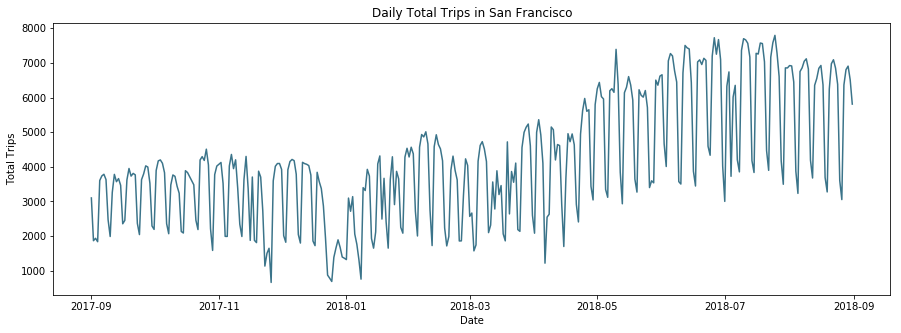

In [15]:
# Total trips per day
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['Trips'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Total Trips")
ax.set_title("Daily Total Trips in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


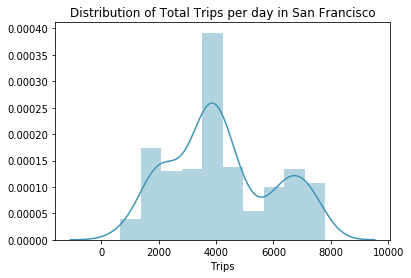

In [16]:
# Distribution of # trips per day
ax = sns.distplot(df['Trips'], color=color_dist)
ax.set_title("Distribution of Total Trips per day in " + city_name);

### <span style='color:#4095b5'>Trips per day of week</span>

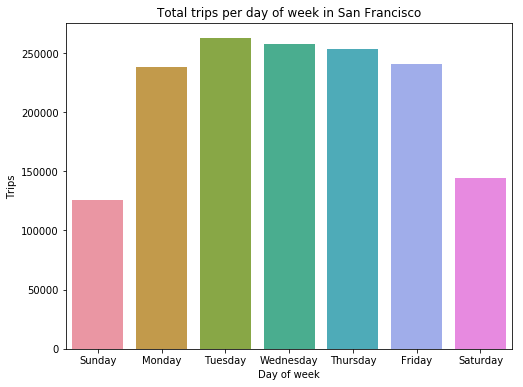

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=df_day['Day'], y=df_day['Trips'], ax=ax);
ax.set_xlabel("Day of week")
ax.set_title("Total trips per day of week in " + city_name)
ax.set_xticklabels(days_of_week);

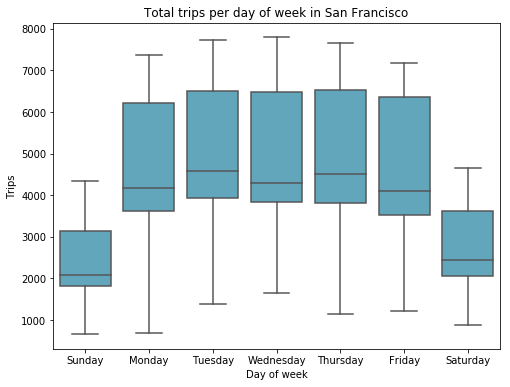

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Day', y='Trips', data=df, color=color_box, ax=ax)
ax.set_title("Total trips per day of week in " + city_name)
ax.set_xticklabels(days_of_week)
ax.set_xlabel("Day of week");

### <span style='color:#4095b5'>Trips per week</span>

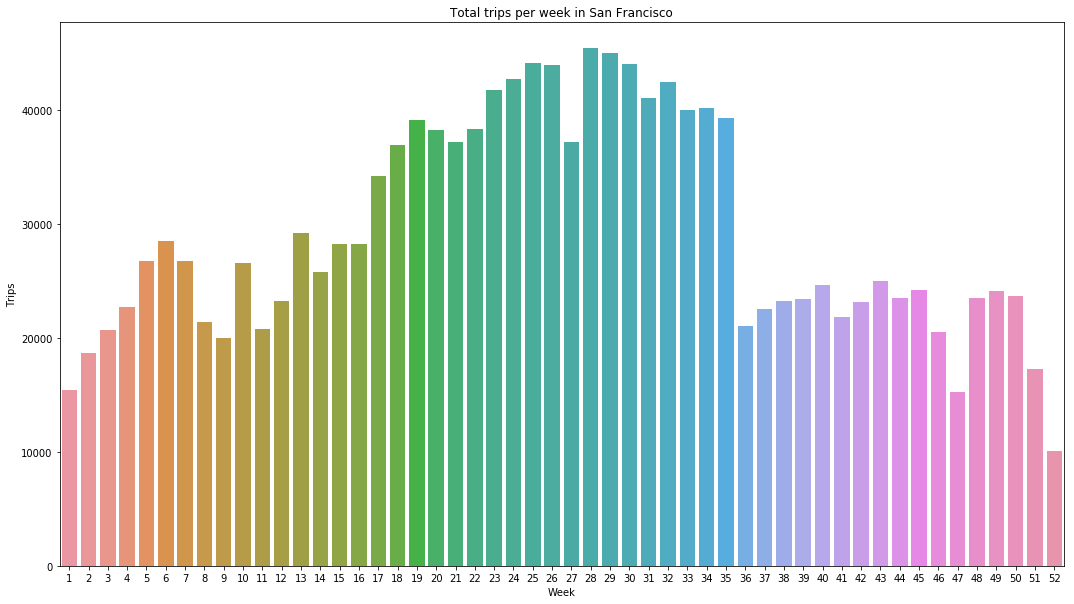

In [19]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_week['Week'], y=df_week['Trips'], ax=ax);
ax.set_xlabel("Week")
ax.set_title("Total trips per week in " + city_name);

### <span style='color:#4095b5'>Trips per month</span>

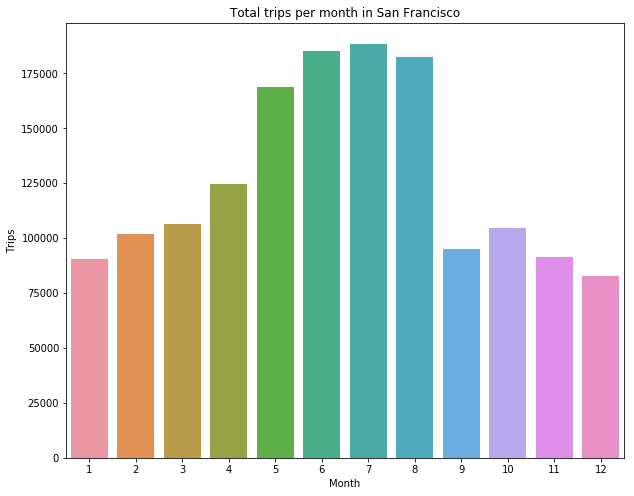

In [20]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df_month['Month'], y=df_month['Trips'], ax=ax);
ax.set_xlabel("Month")
ax.set_title("Total trips per month in " + city_name);

### <span style='color:#4095b5'>Total Durations per time period data.</span>

In [21]:
# This is really interesting to show that weather affects ridership!
df_temp = pd.DataFrame(df.sort_values(by="Total Duration", ascending=True).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
129,2018-01-08,9605.433333,758,737.044108,12.672076,0.972354,Rain,92,3.12,55,4,1,2,1
86,2017-11-26,13024.183333,663,585.243006,19.644319,0.882719,Rain,71,0.18,60,11,11,47,0
217,2018-04-06,14136.066667,1219,1105.446334,11.596445,0.906847,Rain,91,1.11,61,12,4,14,5
114,2017-12-24,17134.616667,786,746.898857,21.799767,0.950253,None,69,0.00,50,3,12,51,0
113,2017-12-23,17249.166667,875,821.039166,19.713333,0.938330,None,65,0.00,48,3,12,51,6
128,2018-01-07,24509.683333,1313,1293.644242,18.666933,0.985258,Fog,85,0.01,50,2,1,1,0
76,2017-11-16,25219.400000,1877,1926.153501,13.436015,1.026187,Rain,87,1.60,58,8,11,46,4


In [22]:
# This is really interesting to show that day of the week (and holidays) affect ridership
df_temp = pd.DataFrame(df.sort_values(by="Total Duration", ascending=False).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
284,2018-06-12,121767.883333,7503,7860.677528,16.229226,1.047671,None,59,0.00,67,15,6,24,2
294,2018-06-22,118721.016667,7071,7255.244136,16.789848,1.026056,None,57,0.00,69,13,6,25,5
300,2018-06-28,116816.900000,7672,7731.139169,15.226395,1.007708,None,56,0.00,65,15,6,26,4
322,2018-07-20,114932.183333,7029,7171.201176,16.351143,1.020231,None,68,0.00,70,8,7,29,5
321,2018-07-19,111737.083333,7557,7835.875460,14.785905,1.036903,None,75,0.00,64,10,7,29,4
327,2018-07-25,111292.850000,7794,7970.510922,14.279298,1.022647,None,78,0.00,63,16,7,30,3
315,2018-07-13,110263.283333,7168,7331.710651,15.382713,1.022839,None,77,0.01,65,14,7,28,5


/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


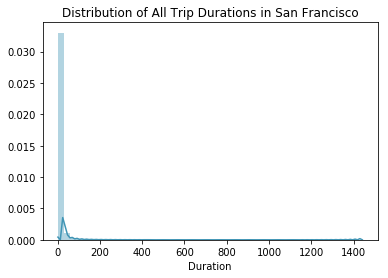

In [23]:
ax = sns.distplot(df_trips['Duration'], color=color_dist)
ax.set_title("Distribution of All Trip Durations in " + city_name);

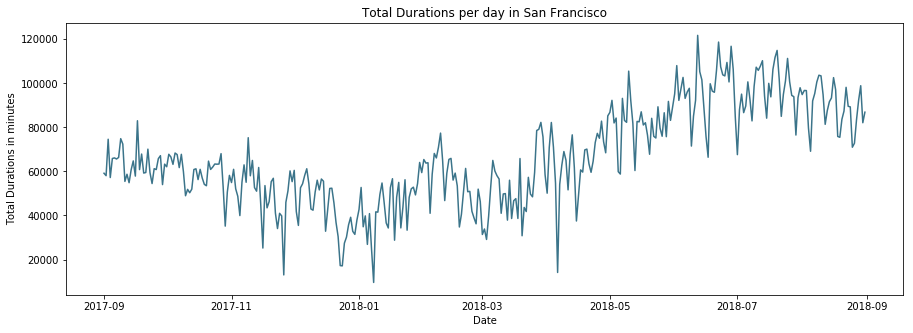

In [24]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['Total Duration'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Total Durations in minutes")
ax.set_title("Total Durations per day in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


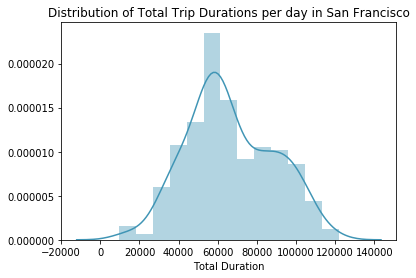

In [25]:
# Distribution of durations per day
ax = sns.distplot(df['Total Duration'], color=color_dist)
ax.set_title("Distribution of Total Trip Durations per day in " + city_name);

### <span style='color:#4095b5'>Total durations per day of week</span>

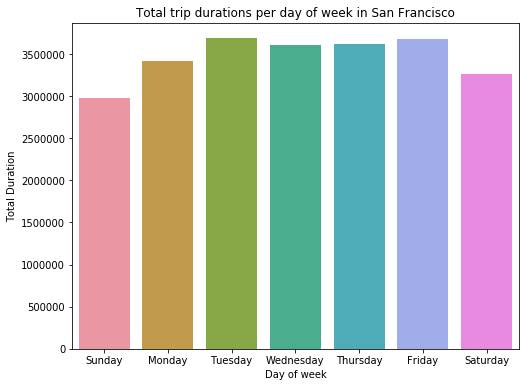

In [26]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=df_day['Day'], y=df_day['Total Duration'], ax=ax);
ax.set_xlabel("Day of week")
ax.set_title("Total trip durations per day of week in " + city_name)
ax.set_xticklabels(days_of_week);

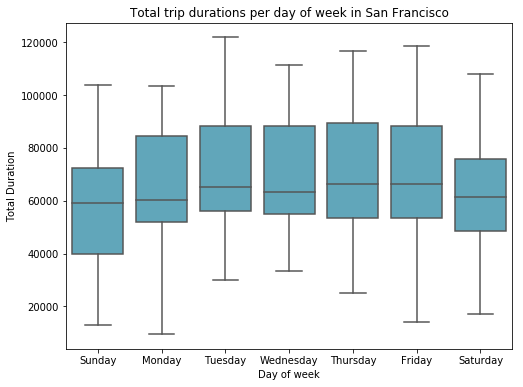

In [27]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Day', y='Total Duration', data=df, color=color_box, ax=ax)
ax.set_title("Total trip durations per day of week in " + city_name)
ax.set_xticklabels(days_of_week)
ax.set_xlabel("Day of week");

### <span style='color:#4095b5'>Total durations per week</span>

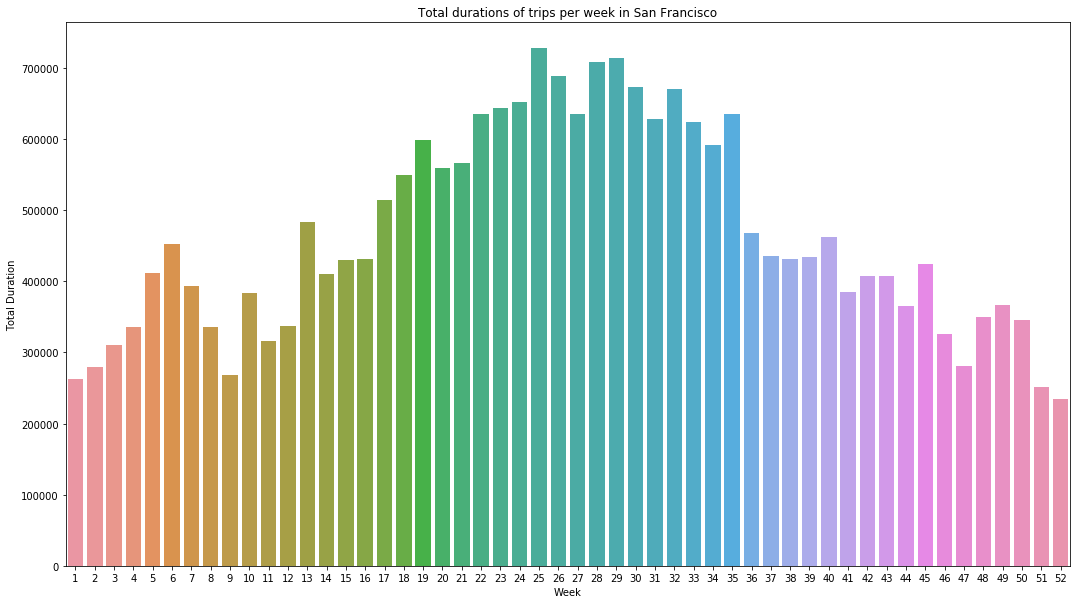

In [28]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_week['Week'], y=df_week['Total Duration'], ax=ax);
ax.set_xlabel("Week")
ax.set_title("Total durations of trips per week in " + city_name);

### <span style='color:#4095b5'>Total durations per month</span>

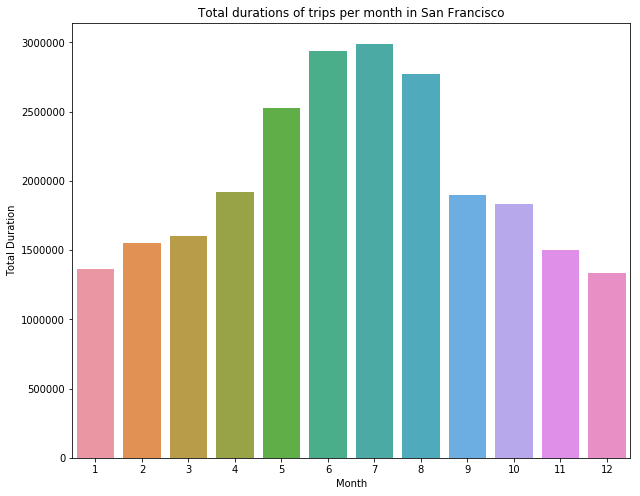

In [29]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df_month['Month'], y=df_month['Total Duration'], ax=ax);
ax.set_xlabel("Month")
ax.set_title("Total durations of trips per month in " + city_name);

### <span style='color:#4095b5'>Average Durations per time period data.</span>

In [30]:
# This is really interesting to show that weather affects ridership!
df_temp = pd.DataFrame(df.sort_values(by="Avg Duration", ascending=True).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
201,2018-03-21,43648.983333,3865,3920.961233,11.293398,1.014479,Rain,80,0.13,60,10,3,12,3
178,2018-02-26,36220.116667,3175,3185.710892,11.407911,1.003374,Rain,65,0.19,50,13,2,9,1
145,2018-01-24,33325.700000,2909,3117.953612,11.456067,1.071830,Rain,77,0.27,53,7,1,4,3
180,2018-02-28,46339.900000,4040,4161.460409,11.470272,1.030064,Rain,71,0.16,49,9,2,9,3
139,2018-01-18,28776.133333,2492,2569.662942,11.547405,1.031165,"Fog,Rain",89,0.15,55,6,1,3,4
217,2018-04-06,14136.066667,1219,1105.446334,11.596445,0.906847,Rain,91,1.11,61,12,4,14,5
200,2018-03-20,30795.650000,2641,2618.214231,11.660602,0.991372,Rain,75,0.42,56,6,3,12,2


In [31]:
# This is really interesting to show that day of the week (and holidays) affect ridership
df_temp = pd.DataFrame(df.sort_values(by="Avg Duration", ascending=False).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
115,2017-12-25,27439.366667,691,621.296665,39.709648,0.899127,None,63,0.0,51,3,12,52,1
2,2017-09-03,74607.416667,1937,1836.873835,38.516994,0.948309,None,55,0.0,77,8,9,35,0
9,2017-09-10,72409.583333,1989,1932.777918,36.405019,0.971733,None,63,0.0,77,8,9,36,0
16,2017-09-17,83005.633333,2454,2212.237966,33.824626,0.901482,None,67,0.0,65,12,9,37,0
37,2017-10-08,67765.333333,2069,2166.561467,32.752699,1.047154,None,55,0.0,66,8,10,40,0
122,2018-01-01,42744.733333,1322,1252.614475,32.333384,0.947515,None,81,0.0,51,2,1,1,1
3,2017-09-04,57228.383333,1839,1802.895652,31.119295,0.980367,None,65,0.0,76,6,9,36,1


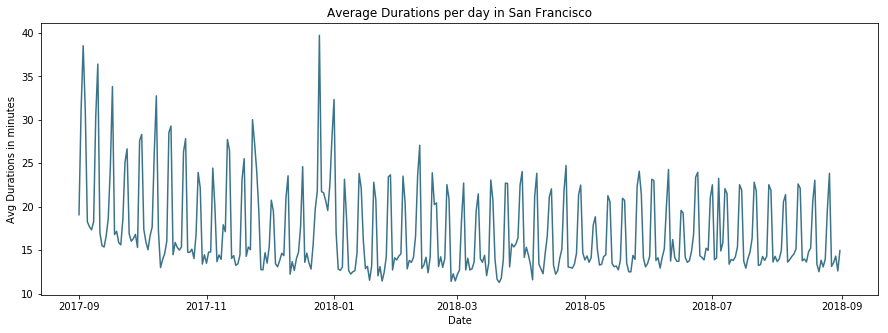

In [32]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['Avg Duration'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Avg Durations in minutes")
ax.set_title("Average Durations per day in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


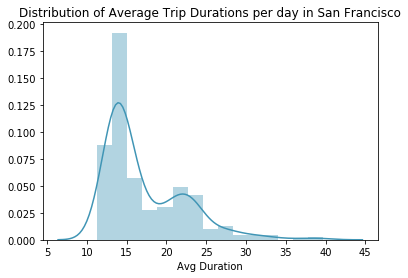

In [33]:
# Distribution of durations per day
ax = sns.distplot(df['Avg Duration'], color=color_dist)
ax.set_title("Distribution of Average Trip Durations per day in " + city_name);

### <span style='color:#4095b5'>Average durations per day of week</span>

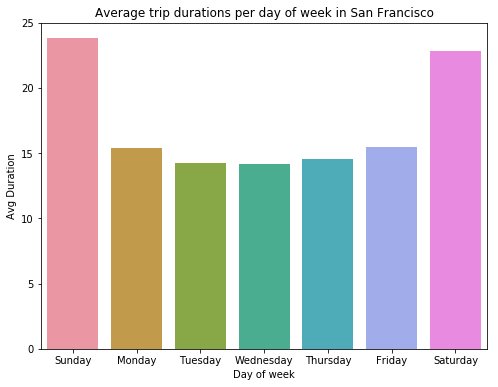

In [34]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=df_day['Day'], y=df_day['Avg Duration'], ax=ax);
ax.set_xlabel("Day of week")
ax.set_title("Average trip durations per day of week in " + city_name)
ax.set_xticklabels(days_of_week);

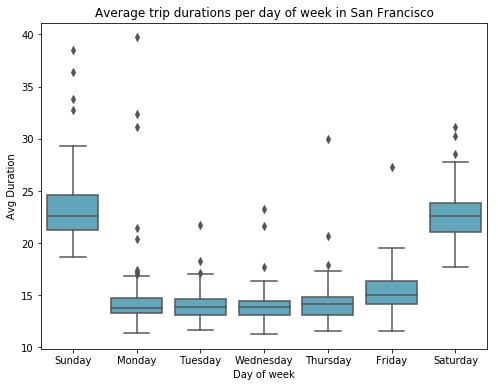

In [35]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Day', y='Avg Duration', data=df, color=color_box, ax=ax)
ax.set_title("Average trip durations per day of week in " + city_name)
ax.set_xticklabels(days_of_week)
ax.set_xlabel("Day of week");

In [36]:
# What are the outliers for San Francisco?
# 3 sep 2017: Labor day weekend
# df[df['Day'] == 0].sort_values(by='Avg Duration', ascending=False)
# 25 dec 2017, 1 jan 2018
# df[df['Day'] == 1].sort_values(by='Avg Duration', ascending=False)
# 23 nov 2017
# df[df['Day'] == 4].sort_values(by='Avg Duration', ascending=False)
# 24 nov 2017
# df[df['Day'] == 5].sort_values(by='Avg Duration', ascending=False)


### <span style='color:#4095b5'>Average durations per week</span>

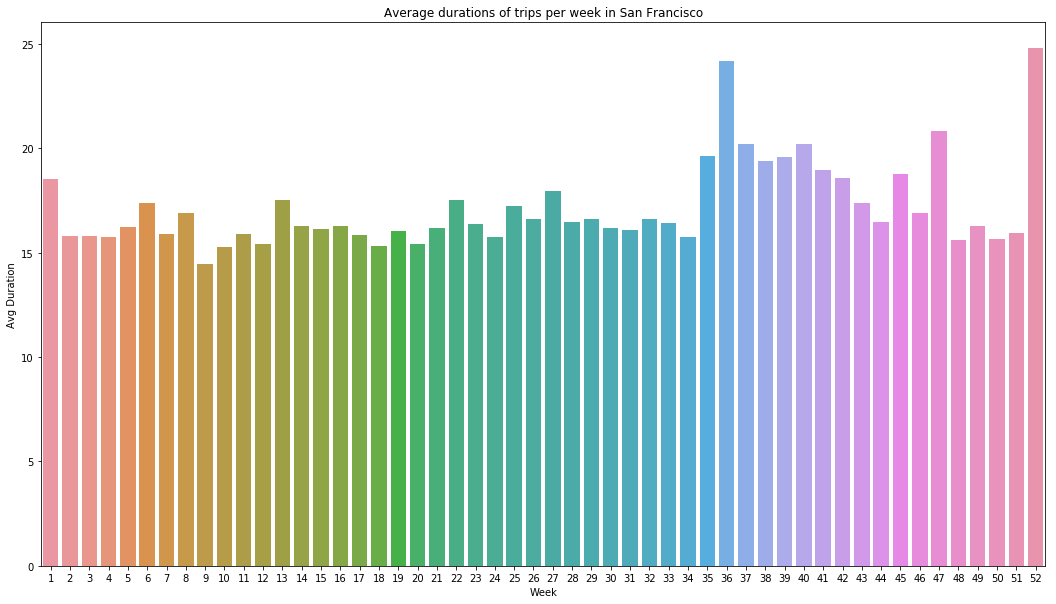

In [37]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_week['Week'], y=df_week['Avg Duration'], ax=ax);
ax.set_xlabel("Week")
ax.set_title("Average durations of trips per week in " + city_name);

### <span style='color:#4095b5'>Average durations per month</span>

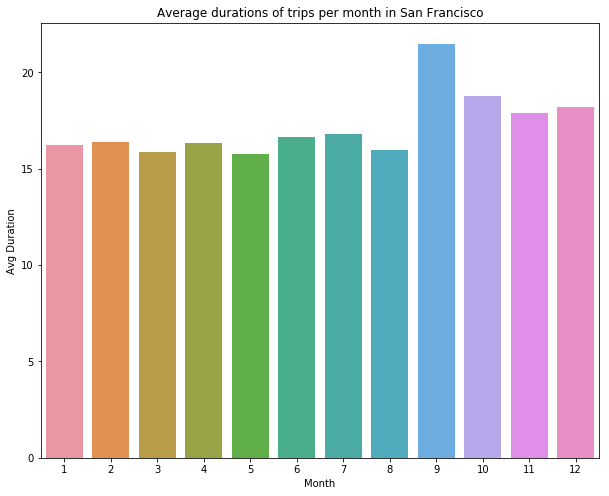

In [38]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df_month['Month'], y=df_month['Avg Duration'], ax=ax);
ax.set_xlabel("Month")
ax.set_title("Average durations of trips per month in " + city_name);

### <span style='color:#4095b5'>Total Distance per time period data.</span>

In [39]:
# This is really interesting to show that weather affects ridership!
df_temp = pd.DataFrame(df.sort_values(by="Total Distance", ascending=True).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
86,2017-11-26,13024.183333,663,585.243006,19.644319,0.882719,Rain,71,0.18,60,11,11,47,0
115,2017-12-25,27439.366667,691,621.296665,39.709648,0.899127,None,63,0.00,51,3,12,52,1
129,2018-01-08,9605.433333,758,737.044108,12.672076,0.972354,Rain,92,3.12,55,4,1,2,1
114,2017-12-24,17134.616667,786,746.898857,21.799767,0.950253,None,69,0.00,50,3,12,51,0
113,2017-12-23,17249.166667,875,821.039166,19.713333,0.938330,None,65,0.00,48,3,12,51,6
83,2017-11-23,34068.466667,1135,976.162411,30.016270,0.860055,None,81,0.00,62,4,11,47,4
217,2018-04-06,14136.066667,1219,1105.446334,11.596445,0.906847,Rain,91,1.11,61,12,4,14,5


In [40]:
# This is really interesting to show that day of the week (and holidays) affect ridership
df_temp = pd.DataFrame(df.sort_values(by="Total Distance", ascending=False).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
327,2018-07-25,111292.850000,7794,7970.510922,14.279298,1.022647,None,78,0.0,63,16,7,30,3
313,2018-07-11,105877.266667,7663,7960.204166,13.816686,1.038784,None,63,0.0,70,12,7,28,3
312,2018-07-10,107314.916667,7698,7945.165665,13.940623,1.032108,None,52,0.0,81,17,7,28,2
298,2018-06-26,109473.550000,7726,7894.792425,14.169499,1.021847,None,58,0.0,66,14,6,26,2
285,2018-06-13,105267.800000,7433,7878.321141,14.162223,1.059911,None,54,0.0,66,17,6,24,3
284,2018-06-12,121767.883333,7503,7860.677528,16.229226,1.047671,None,59,0.0,67,15,6,24,2
321,2018-07-19,111737.083333,7557,7835.875460,14.785905,1.036903,None,75,0.0,64,10,7,29,4


/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


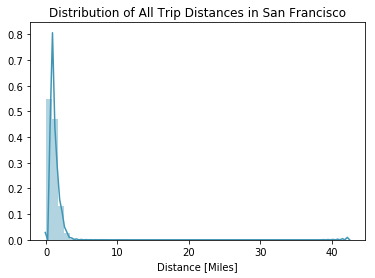

In [41]:
ax = sns.distplot(df_trips['Distance [Miles]'], color=color_dist)
ax.set_title("Distribution of All Trip Distances in " + city_name);

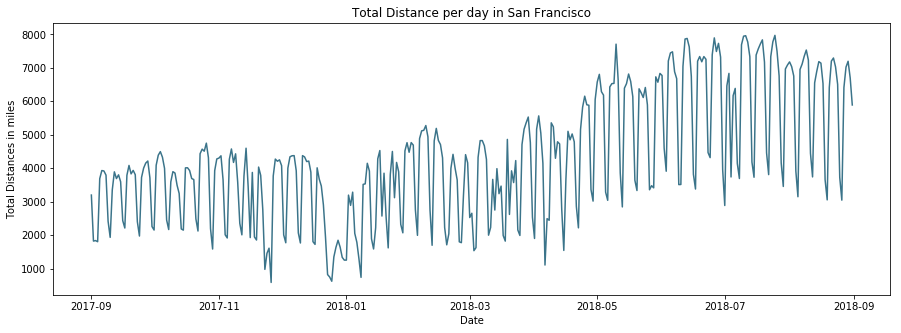

In [42]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['Total Distance'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Total Distances in miles")
ax.set_title("Total Distance per day in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


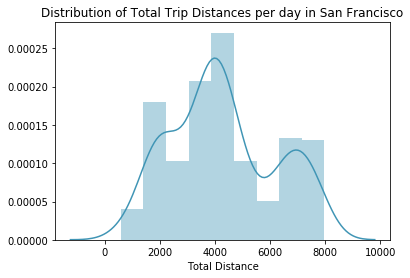

In [43]:
# Distribution of distances per day
ax = sns.distplot(df['Total Distance'], color=color_dist)
ax.set_title("Distribution of Total Trip Distances per day in " + city_name);

### <span style='color:#4095b5'>Total distances per day of week</span>

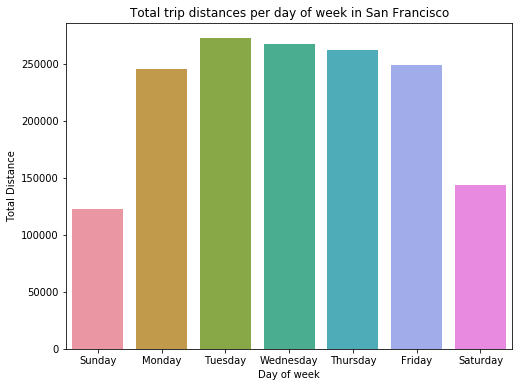

In [44]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=df_day['Day'], y=df_day['Total Distance'], ax=ax);
ax.set_xlabel("Day of week")
ax.set_title("Total trip distances per day of week in " + city_name)
ax.set_xticklabels(days_of_week);

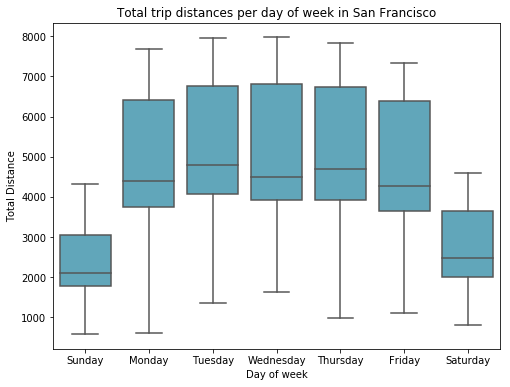

In [45]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Day', y='Total Distance', data=df, color=color_box, ax=ax)
ax.set_title("Total trip distances per day of week in " + city_name)
ax.set_xticklabels(days_of_week)
ax.set_xlabel("Day of week");

### <span style='color:#4095b5'>Total distances per week</span>

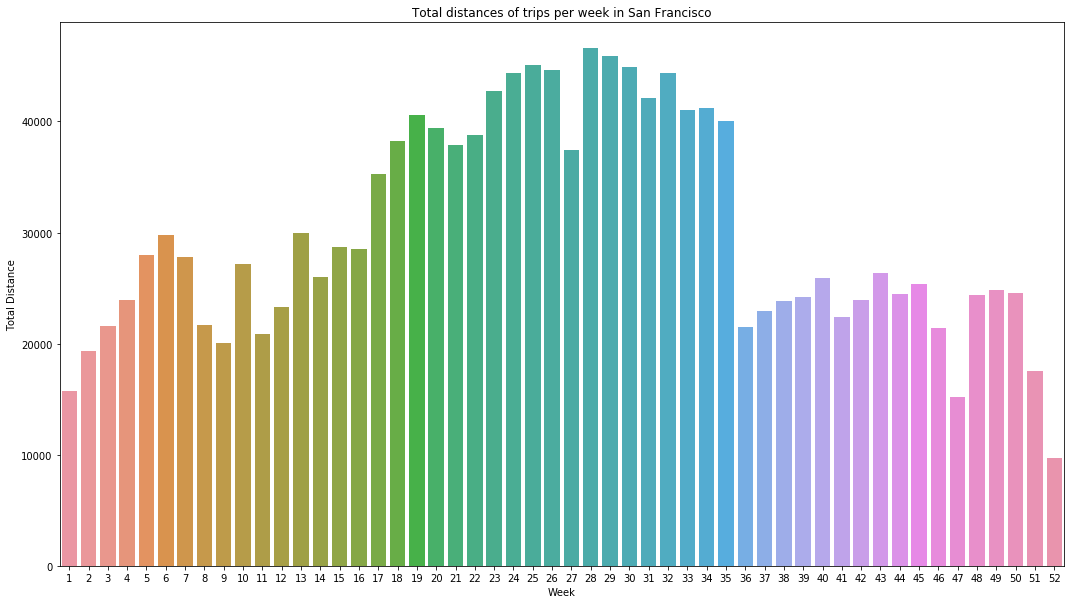

In [46]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_week['Week'], y=df_week['Total Distance'], ax=ax);
ax.set_xlabel("Week")
ax.set_title("Total distances of trips per week in " + city_name);

### <span style='color:#4095b5'>Total distances per month</span>

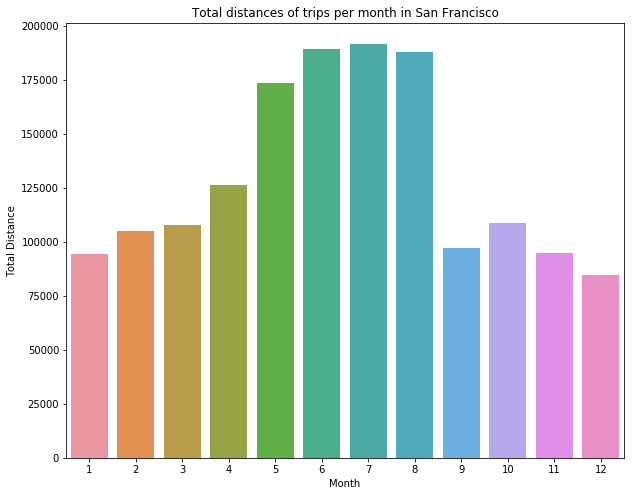

In [47]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df_month['Month'], y=df_month['Total Distance'], ax=ax);
ax.set_xlabel("Month")
ax.set_title("Total distances of trips per month in " + city_name);

### <span style='color:#4095b5'>Average Distances per time period data.</span>

In [48]:
# This is really interesting to show that weather affects ridership!
df_temp = pd.DataFrame(df.sort_values(by="Avg Distance", ascending=True).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
83,2017-11-23,34068.466667,1135,976.162411,30.016270,0.860055,None,81,0.00,62,4,11,47,4
86,2017-11-26,13024.183333,663,585.243006,19.644319,0.882719,Rain,71,0.18,60,11,11,47,0
115,2017-12-25,27439.366667,691,621.296665,39.709648,0.899127,None,63,0.00,51,3,12,52,1
16,2017-09-17,83005.633333,2454,2212.237966,33.824626,0.901482,None,67,0.00,65,12,9,37,0
217,2018-04-06,14136.066667,1219,1105.446334,11.596445,0.906847,Rain,91,1.11,61,12,4,14,5
226,2018-04-15,37498.066667,1700,1542.346791,22.057686,0.907263,Rain,61,0.05,57,10,4,15,0
212,2018-04-01,50123.350000,2084,1899.801586,24.051512,0.911613,None,64,0.00,59,12,4,13,0


In [49]:
# This is really interesting to show that day of the week (and holidays) affect ridership
df_temp = pd.DataFrame(df.sort_values(by="Avg Distance", ascending=False).head(7)[['Start Date', 'Total Duration', 'Trips', 'Total Distance',
       'Avg Duration', 'Avg Distance', 'events', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Month', 'Week', 'Day']])
df_temp

,Start Date,Total Duration,Trips,Total Distance,Avg Duration,Avg Distance,events,hum_avg,prec,temp_avg,wind_avg,Month,Week,Day
146,2018-01-25,48242.200000,3869,4172.652985,12.468907,1.078484,None,67,0.12,52,7,1,4,4
54,2017-10-25,63278.516667,4184,4507.641775,15.123928,1.077352,None,56,0.00,73,4,10,43,3
154,2018-02-02,63792.550000,4374,4689.875507,14.584488,1.072217,None,63,0.00,62,3,2,5,5
145,2018-01-24,33325.700000,2909,3117.953612,11.456067,1.071830,Rain,77,0.27,53,7,1,4,3
33,2017-10-04,63212.316667,4199,4495.362758,15.054136,1.070579,None,55,0.00,64,9,10,40,3
157,2018-02-05,58721.283333,4568,4884.359153,12.854922,1.069256,None,69,0.00,63,6,2,6,1
74,2017-11-14,61791.366667,4300,4597.338952,14.370085,1.069149,None,66,0.00,58,6,11,46,2


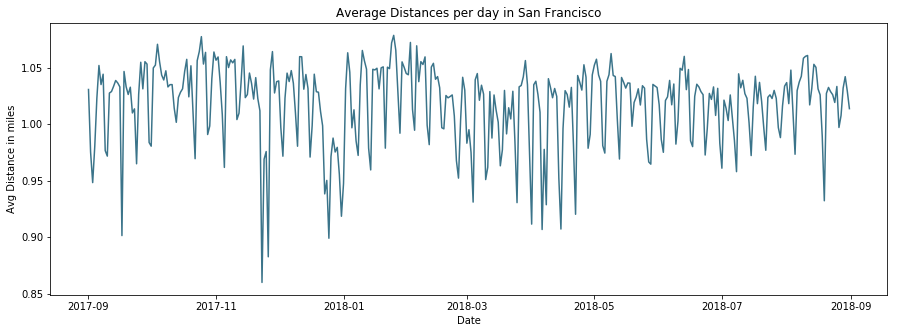

In [50]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['Avg Distance'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Avg Distance in miles")
ax.set_title("Average Distances per day in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


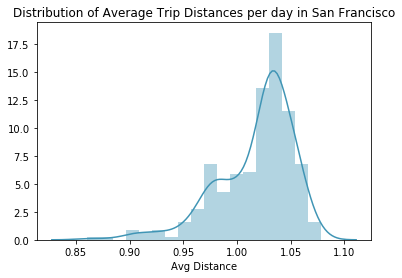

In [51]:
# Distribution of distances per day
ax = sns.distplot(df['Avg Distance'], color=color_dist)
ax.set_title("Distribution of Average Trip Distances per day in " + city_name);

### <span style='color:#4095b5'>Average distances per day of week</span>

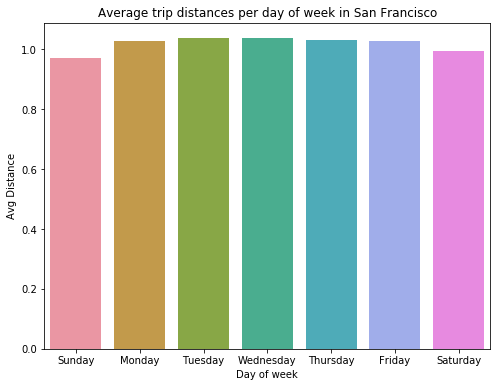

In [52]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x=df_day['Day'], y=df_day['Avg Distance'], ax=ax);
ax.set_xlabel("Day of week")
ax.set_title("Average trip distances per day of week in " + city_name)
ax.set_xticklabels(days_of_week);

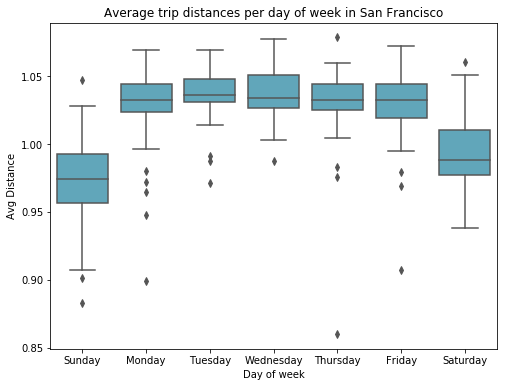

In [53]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.boxplot(x='Day', y='Avg Distance', data=df, color=color_box, ax=ax)
ax.set_title("Average trip distances per day of week in " + city_name)
ax.set_xticklabels(days_of_week)
ax.set_xlabel("Day of week");

### <span style='color:#4095b5'>Average distances per week</span>

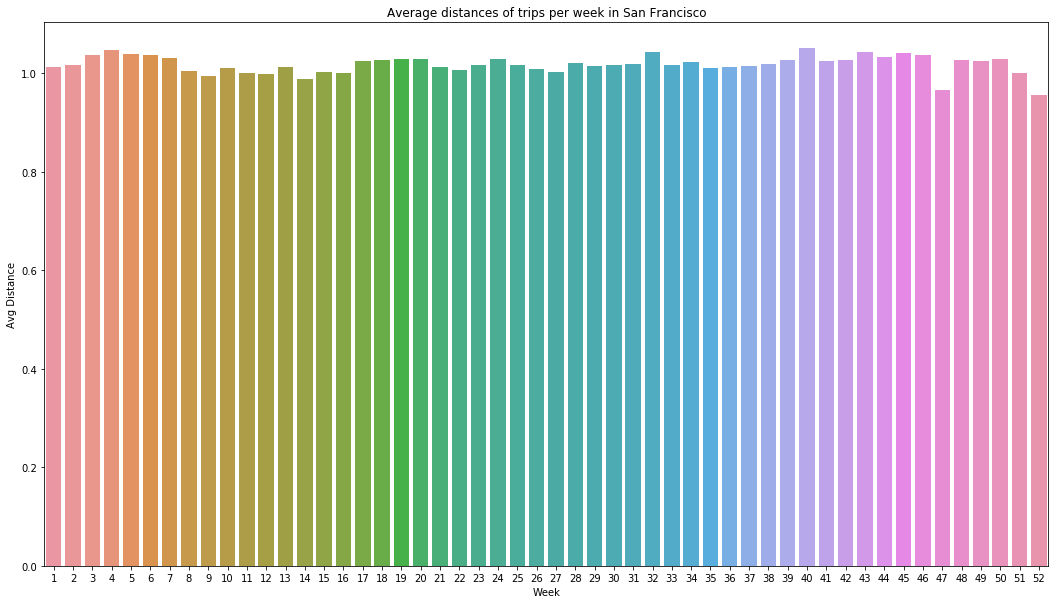

In [54]:
fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_week['Week'], y=df_week['Avg Distance'], ax=ax);
ax.set_xlabel("Week")
ax.set_title("Average distances of trips per week in " + city_name);

### <span style='color:#4095b5'>Average distances per month</span>

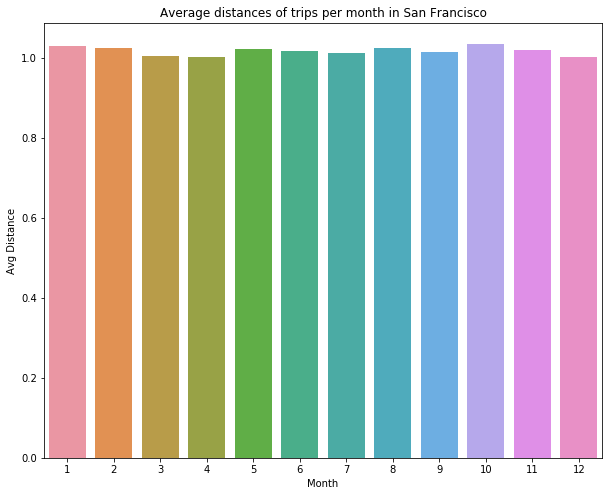

In [55]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df_month['Month'], y=df_month['Avg Distance'], ax=ax);
ax.set_xlabel("Month")
ax.set_title("Average distances of trips per month in " + city_name);

<hr>
<a name="plot_bike"> </a>
## <span style='color:#3b748a'>IV. Plot bike data.</span>


In [56]:
df_bikes = df_trips.groupby(['Bike Name'], as_index=False).agg({
        "Duration" : ['sum', 'mean', 'count'],
        "Distance [Miles]" : ['sum', 'mean']
    })

df_bikes.columns = ["_".join(x) for x in df_bikes.columns.ravel()]
df_bikes.rename(columns={
    'Bike Name_' : 'Bike Name',
    'Duration_count': 'Trips', 
    'Duration_sum' : 'Total Duration', 
    'Duration_mean' : 'Avg Duration', 
    'Distance [Miles]_sum' : 'Total Distance',
    'Distance [Miles]_mean' : 'Avg Distance'
}, inplace=True)


 #### <span style='color:#4095b5'>Export the dataframe.</span>

In [57]:
df_bikes.to_csv('../data/' + city_code + '/bikes.csv', index=False)

 #### <span style='color:#4095b5'>Explore the data.</span>

In [58]:
df_bikes.describe()

,Bike Name,Total Duration,Avg Duration,Trips,Total Distance,Avg Distance
count,4289.000000,4289.000000,4289.000000,4289.000000,4289.000000,4289.000000
mean,2234.913266,5652.287643,16.561510,354.948473,364.080929,0.982390
std,1278.386118,3954.481576,9.272836,242.328676,264.440965,0.155014
min,10.000000,3.300000,3.300000,1.000000,0.000000,0.000000
25%,1139.000000,2564.666667,13.721212,170.000000,148.045552,0.929025
50%,2240.000000,4539.483333,15.470874,286.000000,280.132175,1.028458
75%,3335.000000,8851.433333,17.558278,572.000000,609.116797,1.070587
max,4466.000000,16788.933333,475.094444,913.000000,998.241627,1.949274


/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


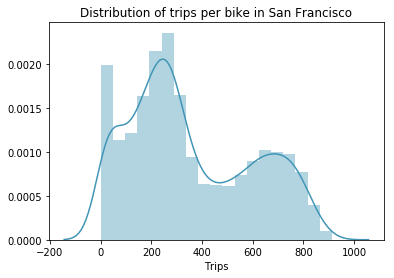

In [59]:
ax = sns.distplot(df_bikes['Trips'], color=color_dist)
ax.set_title("Distribution of trips per bike in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


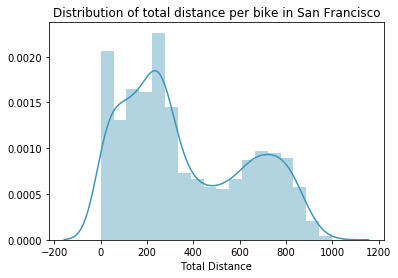

In [60]:
ax = sns.distplot(df_bikes['Total Distance'], color=color_dist)
ax.set_title("Distribution of total distance per bike in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


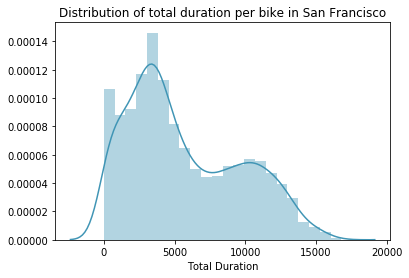

In [61]:
ax = sns.distplot(df_bikes['Total Duration'], color=color_dist)
ax.set_title("Distribution of total duration per bike in " + city_name);

<hr>
<a name="plot_trip_other"> </a>
## <span style='color:#3b748a'>V. Plot other trip data.</span>

### <span style='color:#4095b5'>Hub data</span>

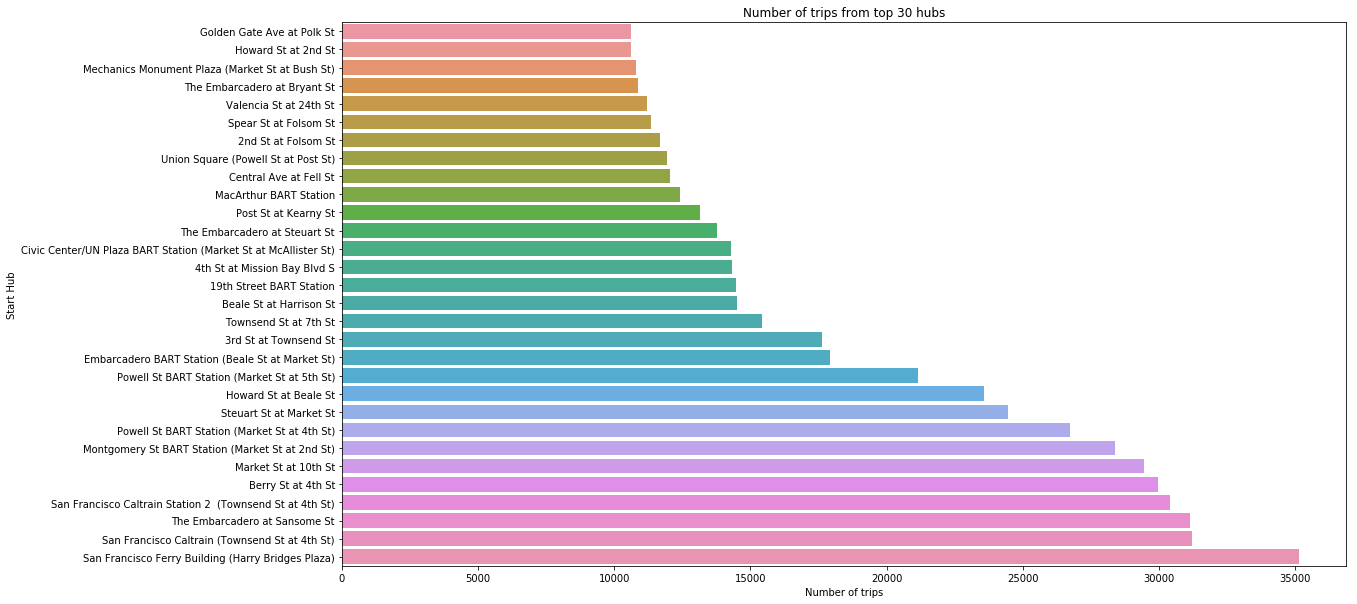

In [62]:
# Plot start station usage
df_temp = pd.DataFrame(df_trips.groupby(['Start Hub']).size(), columns=['count'])
df_temp = pd.DataFrame(df_temp.sort_values(by="count", ascending=False).head(30))
df_temp.sort_values('count', inplace=True)

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_temp['count'], y=df_temp.index, ax=ax);
ax.set_xlabel("Number of trips")
ax.set_title("Number of trips from top 30 hubs");

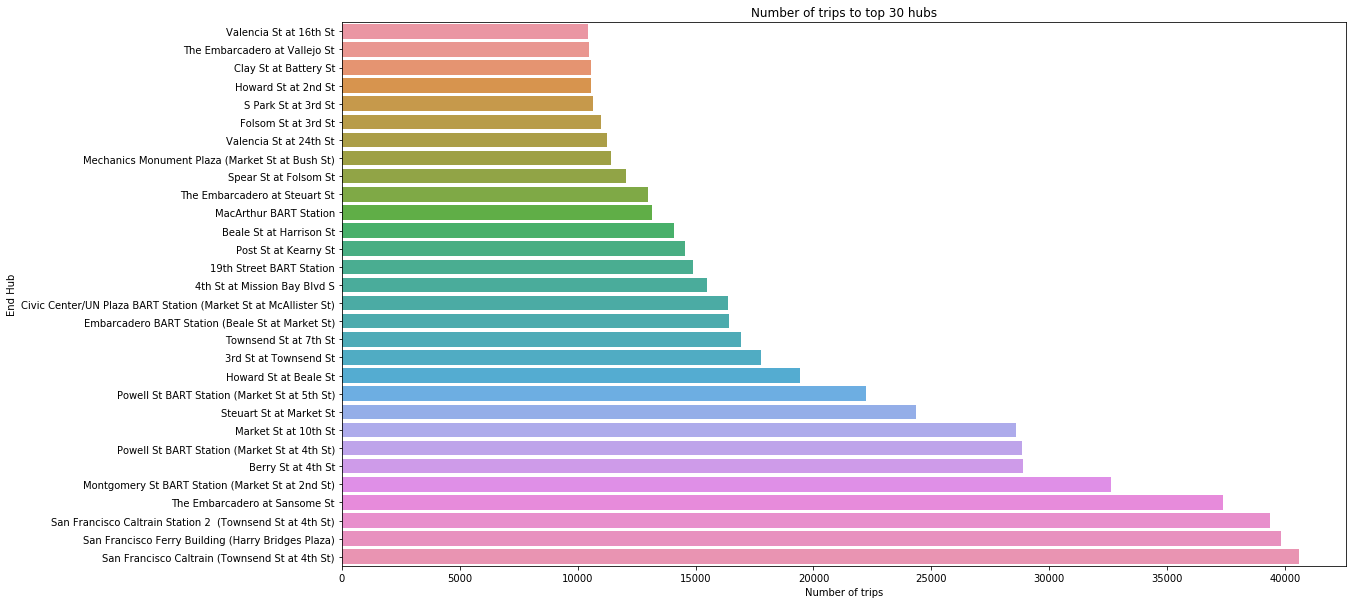

In [63]:
# Plot end station usage
df_temp = pd.DataFrame(df_trips.groupby(['End Hub']).size(), columns=['count'])
df_temp = pd.DataFrame(df_temp.sort_values(by="count", ascending=False).head(30))
df_temp.sort_values('count', inplace=True)

fig, ax = plt.subplots(figsize=(18, 10))
sns.barplot(x=df_temp['count'], y=df_temp.index, ax=ax);
ax.set_xlabel("Number of trips")
ax.set_title("Number of trips to top 30 hubs");

<hr>
<a name="plot_weather"> </a>
## <span style='color:#3b748a'>VI. Plot weather and daylight data.</span>

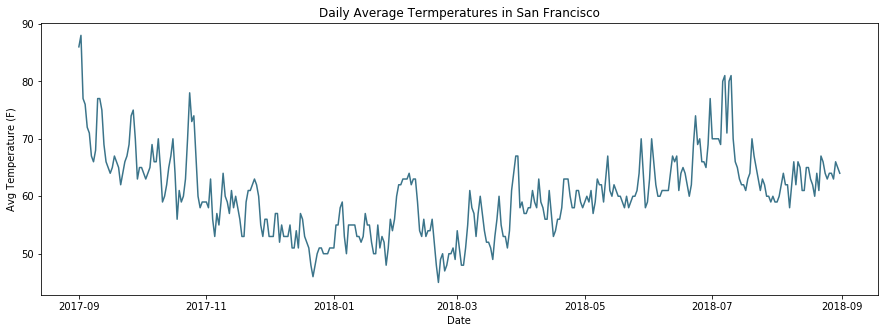

In [64]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['temp_avg'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Avg Temperature (F)")
ax.set_title("Daily Average Termperatures in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


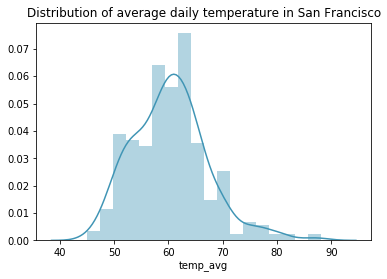

In [65]:
# Distribution of avg temperatures per day
ax = sns.distplot(df['temp_avg'], color=color_dist)
ax.set_title("Distribution of average daily temperature in " + city_name);

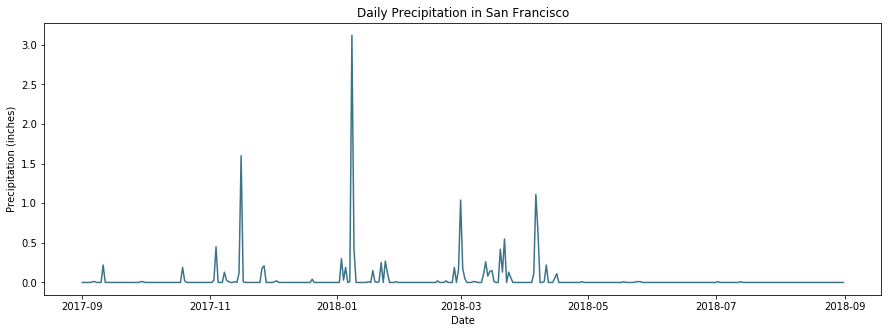

In [66]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['prec'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Precipitation (inches)")
ax.set_title("Daily Precipitation in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


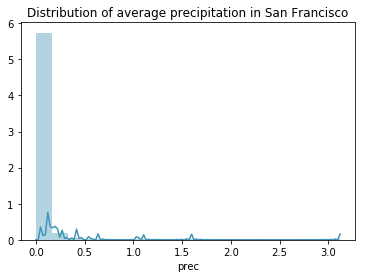

In [67]:
# Distribution of avg precipitation per day
ax = sns.distplot(df['prec'], color=color_dist)
ax.set_title("Distribution of average precipitation in " + city_name);

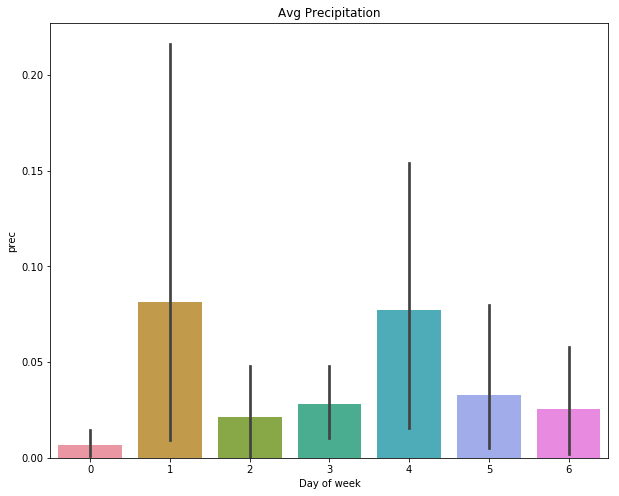

In [68]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x=df['Day'], y=df['prec'], ax=ax);
ax.set_xlabel("Day of week")
ax.set_title("Avg Precipitation");

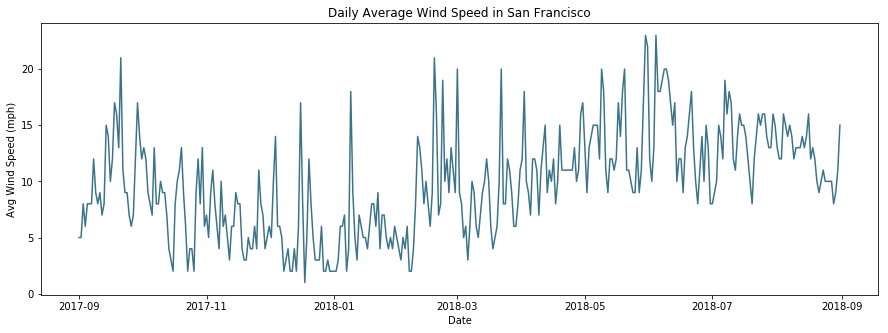

In [69]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['wind_avg'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Avg Wind Speed (mph)")
ax.set_title("Daily Average Wind Speed in " + city_name);

/Users/gwyneth/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6499: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")


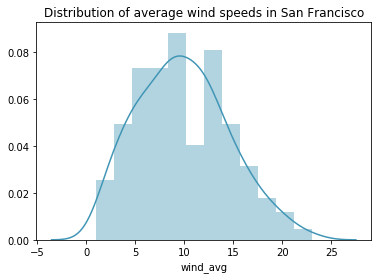

In [70]:
# Distribution of avg wind speeds per day
ax = sns.distplot(df['wind_avg'], color=color_dist)
ax.set_title("Distribution of average wind speeds in " + city_name);

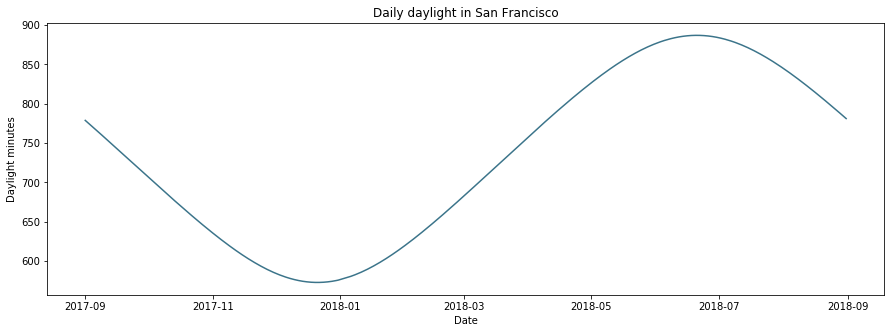

In [71]:
plt.figure(figsize=(15,5))
plt.plot(df['Start Date'], df['Daylight'], color=color_line);
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Daylight minutes")
ax.set_title("Daily daylight in " + city_name);

<hr>
<a name="corr"></a>

## <span style='color:#3b748a'>VII. Plot correlations.</span>

In [129]:
# Feature engineering
peak = 177
df['Peak'] = np.minimum(abs(df['DayOfYear'] - peak), abs(365+peak-df['DayOfYear']))

In [130]:
df_corr = df[['Trips', 'hum_avg', 'prec', 'temp_avg',
       'wind_avg', 'Peak', 'Daylight', 'Date', 'Day', 'DayOfYear', 'Week', 'Month',
       'Year']].copy()

In [131]:
# What features are highly correlated with # of trips?
df_corr.corr().sort_values(by="Trips", ascending = True)

,Trips,hum_avg,prec,temp_avg,wind_avg,Peak,Daylight,Date,Day,DayOfYear,Week,Month,Year
Peak,-0.667134,0.103187,0.135545,-0.573637,-0.663080,1.000000,-0.991624,-6.948363e-01,-1.313055e-03,0.095388,0.093594,0.091887,-0.483579
prec,-0.202215,0.231562,1.000000,-0.102252,-0.010212,0.135545,-0.128921,-6.244554e-02,4.830585e-03,-0.127694,-0.126640,-0.121437,0.039929
Month,-0.083285,-0.107963,-0.121437,0.237145,-0.120240,0.091887,-0.147077,-3.408006e-01,5.541668e-03,0.996504,0.996273,1.000000,-0.818367
DayOfYear,-0.083145,-0.098987,-0.127694,0.226108,-0.122052,0.095388,-0.150461,-3.351648e-01,6.318506e-03,1.000000,0.999816,0.996504,-0.817057
Week,-0.072747,-0.099143,-0.126640,0.227126,-0.120766,0.093594,-0.148638,-3.326528e-01,1.548848e-03,0.999816,1.000000,0.996273,-0.815407
hum_avg,-0.053806,1.000000,0.231562,-0.329148,0.007562,0.103187,-0.081456,1.467947e-01,5.159513e-02,-0.098987,-0.099143,-0.107963,0.150407
Day,0.033348,0.051595,0.004831,0.021186,0.025569,-0.001313,0.001222,-5.417101e-18,1.000000e+00,0.006319,0.001549,0.005542,-0.003867
temp_avg,0.325356,-0.329148,-0.102252,1.000000,0.201834,-0.573637,0.520549,7.861757e-02,2.118569e-02,0.226108,0.227126,0.237145,-0.090257
Year,0.441254,0.150407,0.039929,-0.090257,0.373627,-0.483579,0.537258,8.170572e-01,-3.866624e-03,-0.817057,-0.815407,-0.818367,1.000000
wind_avg,0.447633,0.007562,-0.010212,0.201834,1.000000,-0.663080,0.670629,4.884961e-01,2.556911e-02,-0.122052,-0.120766,-0.120240,0.373627


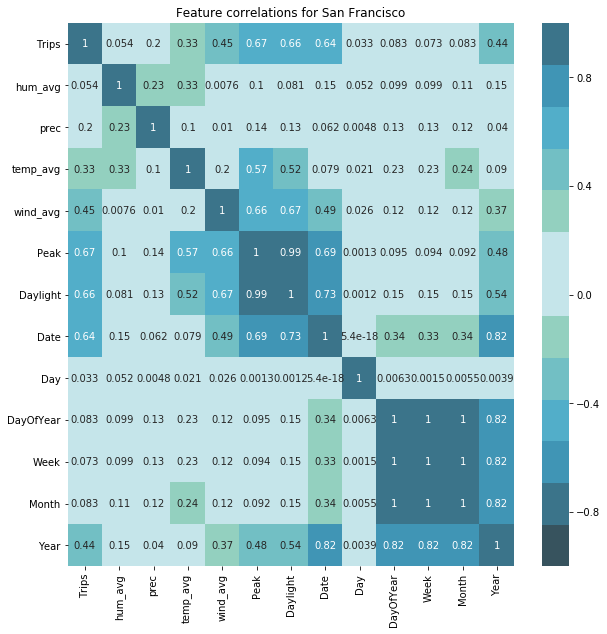

In [132]:
colors_heat = ['#37535e','#3b748a', '#4095b5', '#52aec9', '#72bfc4', '#93d0bf', '#c5e5eaff', 
               '#c5e5eaff', '#93d0bf', '#72bfc4', '#52aec9', '#4095b5', '#3b748a'  
               ]

plt.figure(figsize=(10,10))
ax = sns.heatmap(df_corr.corr().abs(),
            vmin=-1,vmax=1,  cmap = colors_heat, annot=True)
ax.set_title("Feature correlations for " + city_name);

### <span style='color:#4095b5'>Scatterplots</span>

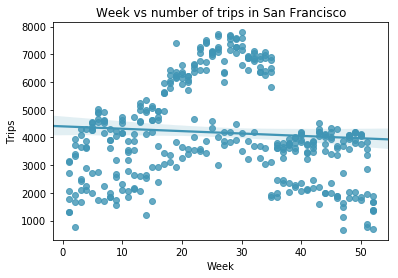

In [133]:
sns.regplot(x=df['Week'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Week")
ax.set_ylabel("Trips")
ax.set_title("Week vs number of trips in " + city_name);

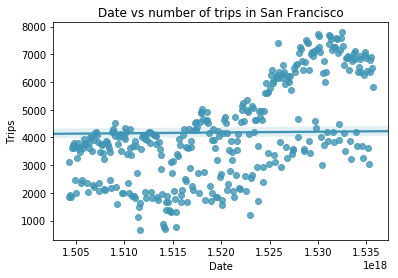

In [134]:
sns.regplot(x=df['Date'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Date")
ax.set_ylabel("Trips")
ax.set_title("Date vs number of trips in " + city_name);

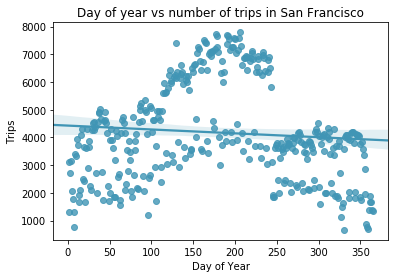

In [135]:
sns.regplot(x=df['DayOfYear'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Day of Year")
ax.set_ylabel("Trips")
ax.set_title("Day of year vs number of trips in " + city_name);

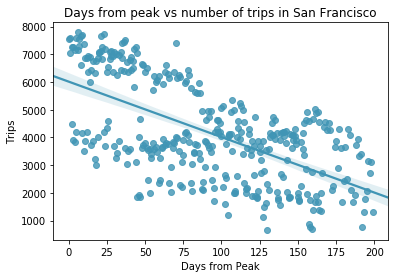

In [136]:
peak = 200
df['Peak'] = np.minimum(abs(df['DayOfYear'] - peak), abs(365+peak-df['DayOfYear']))

sns.regplot(x=df['Peak'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Days from Peak")
ax.set_ylabel("Trips")
ax.set_title("Days from peak vs number of trips in " + city_name);

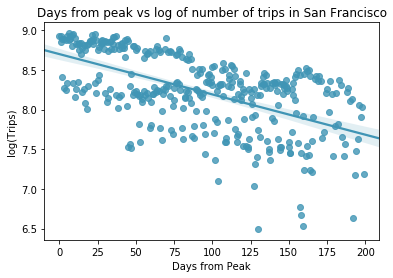

In [137]:
sns.regplot(x=df['Peak'], y=np.log(df["Trips"]), color=color_reg)
ax = plt.gca()
ax.set_xlabel("Days from Peak")
ax.set_ylabel("log(Trips)")
ax.set_title("Days from peak vs log of number of trips in " + city_name);

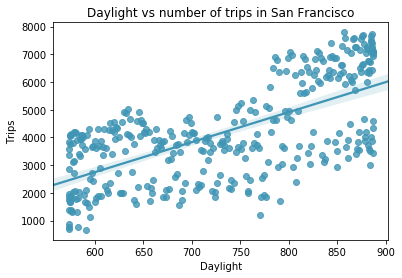

In [138]:
sns.regplot(x=df['Daylight'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Daylight")
ax.set_ylabel("Trips")
ax.set_title("Daylight vs number of trips in " + city_name);

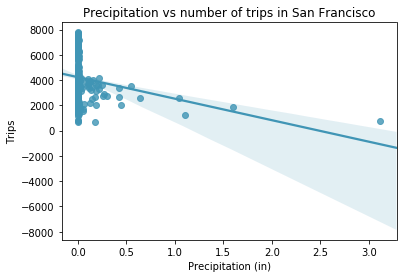

In [139]:
sns.regplot(x=df['prec'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Precipitation (in)")
ax.set_ylabel("Trips")
ax.set_title("Precipitation vs number of trips in " + city_name);

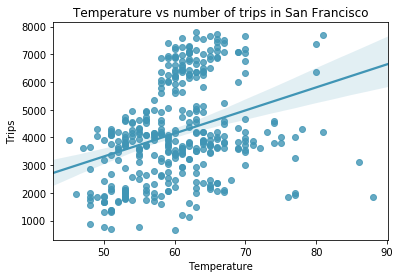

In [140]:
sns.regplot(x=df['temp_avg'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Temperature")
ax.set_ylabel("Trips")
ax.set_title("Temperature vs number of trips in " + city_name);

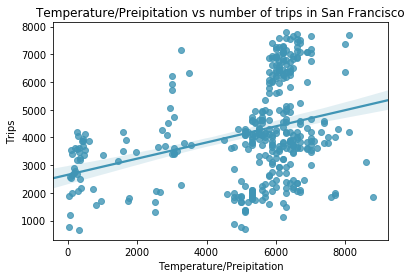

In [141]:
sns.regplot(x=df['temp_avg']/(df['prec']+.01), y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Temperature/Preipitation")
ax.set_ylabel("Trips")
ax.set_title("Temperature/Preipitation vs number of trips in " + city_name);

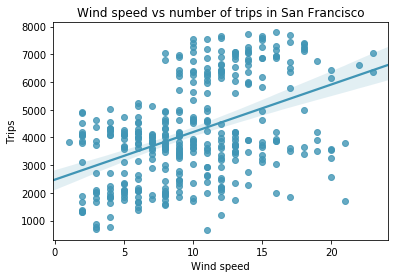

In [142]:
sns.regplot(x=df['wind_avg'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Wind speed")
ax.set_ylabel("Trips")
ax.set_title("Wind speed vs number of trips in " + city_name);

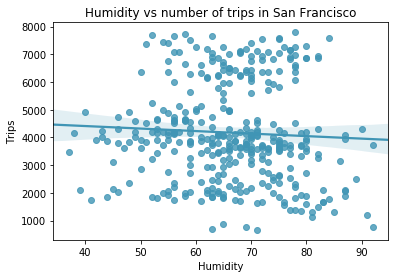

In [143]:
sns.regplot(x=df['hum_avg'], y=df["Trips"], color=color_reg)
ax = plt.gca()
ax.set_xlabel("Humidity")
ax.set_ylabel("Trips")
ax.set_title("Humidity vs number of trips in " + city_name);

<hr>
<a name="future"></a>

## <span style='color:#3b748a'>VIII. Further work.</span>

* Bike data
* Time of day
* Cumulative usage
* Hub usage
* Lat/Long improvements


<hr>
<a name="store"></a>

## <span style='color:#3b748a'>IX. For future reference.</span>